## Домашнє завдання: Логістична регресія з scikit learn

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

Необхідні імпорти:

In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Завдання 1

In [3]:
file_name = '/content/drive/MyDrive/ML/data/bccp/train.csv'

In [4]:
train_data = pd.read_csv(file_name)

In [5]:
train_data.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15779985.0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,15650086.0,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,15733602.0,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,15645794.0,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,15633840.0,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [6]:
train_data.shape

(15000, 14)

In [7]:
train_df, val_df = train_test_split(train_data, test_size=0.2, random_state=42, stratify=train_data['Exited'])

### Завдання 2

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

Проаналізувавши попередно дані, можемо виключити з датасетів можемо сказати, що деякі колонки не несуть у собі інформації, яка могла б бути корисною при моджелюванні, тому не будемо їх включати у модель, і відразу відсіємо.

До таких колонок належать 'id', 'Surname', 'CustomerId'.

In [8]:
input_cols = [col for col in train_data.columns if col not in ['Exited', 'id', 'Surname', 'CustomerId']]
target_col = 'Exited'
print(input_cols)

['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


In [9]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()
val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

### Завдання 3

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


**Спостереження**:
Бачимо, що в датафреймі маємо колонки Surname, Geography та Gender що мають тип object, тому доцільно перевірити які насправді типи мають значення у цих колонках.

Також бачимо, що у колонках відсутні пропущенні значення.

In [11]:
for col in train_data.select_dtypes(include=["object"]):
    print(train_data[col].apply(type).value_counts())

Surname
<class 'str'>    15000
Name: count, dtype: int64
Geography
<class 'str'>    15000
Name: count, dtype: int64
Gender
<class 'str'>    15000
Name: count, dtype: int64


**Спостереження**:
Бачимо, що Surname, Geography та Gender насправді це строки.

Кількість унікальних значень у категоріальних колонках:

In [12]:
for col in train_data.select_dtypes(include=["object"]):
    print(f"{col}: {train_data[col].nunique()}")

Surname: 764
Geography: 3
Gender: 2


Surname має 764 унікальних значень, і не я змінною, яка потенційно може впливати на цільову змінну, тому немає сенсу її в подальшому кодувати, отже виключення її на попередньому етапі цілком виправдане.

In [13]:
categorical_cols = [col for col in train_data.select_dtypes(include=['object']).columns if col in input_cols]
categorical_cols

['Geography', 'Gender']

Отже сворили `categorical_cols` на основі `input_cols` з попереднього етапу де виключили декілька неінформативних колонок.

In [14]:
numeric_cols = [col for col in train_data.select_dtypes(include=['int64', 'float64']).columns if col in input_cols]
print(numeric_cols)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']


Подібним чином створено і `numeric_cols` на основі input_cols з попперенього етапу де виключили декілька неінформативних колонок, в тому числі і числових

#### Висновок:
В наборі маємо 10 колок числових та 3 категоріальних.

- Числові колонки: CustomerId, CreditScore, Age, Tenure, Balance, NumOfProducts, HasCrCard, IsActiveMember, EstimatedSalary. Також Exited - таргет колоонка, що також є числовою.
- Категоріальні колонки: Surname, Geography, Gender.
  - Сред категоріальних колонок маємо 1 бінарну - Gender.


Ще на попередньому етапі було виключено такі колонки як  'id', 'Surname', 'CustomerId', тому сформовані набори числових і категоріальних змінних, що будуть передаватися на подальший препроцесинг уже не мають цих стовпчиків.  

### Завдання 4

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

**Кроки передобробки**

Відомо, що датафрейм не має пропущених значень, та що маємо 3 категоріальних колонки (Surname, Geography, Gender).
- Gender - бінарна колонка, є сенс її закодувати.
-Geography - має три унікальні значення, тож також є сенс її кодувати.

Можемо використати OneHotEncoding для кодування обох колонок.


- Surname - має 764 унікальних значення, кодувати таку колонку немає сенсу, адже це просто прізвище, і наврядчи тут можливо знайти якийсь патерн як прізвище впливає на те, що клієнт залишиться у банку. Тож можемо видалити цю колонку. (Було видалено раніше)


Для того, щоб зменшти влив на модель різних факту різних масштаб ознак - виконаємо масштабуваня данних за допомогою MinMaxScaler.


Кодування колонкок категоріальних змінних:

In [15]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(train_inputs[categorical_cols])

In [16]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male']


In [17]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])

In [18]:
display(train_inputs.head()), display(val_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,682.0,France,Male,30.0,1.0,131394.56,1.0,1.0,1.0,143952.24,1.0,0.0,0.0,0.0,1.0
10393,684.0,France,Female,39.0,2.0,178058.06,1.0,1.0,0.0,145518.31,1.0,0.0,0.0,1.0,0.0
80,705.0,Germany,Male,35.0,6.0,116320.68,2.0,1.0,0.0,174431.01,0.0,1.0,0.0,0.0,1.0
3365,669.0,Spain,Male,58.0,0.0,0.00,2.0,0.0,1.0,51565.98,0.0,0.0,1.0,0.0,1.0
12236,707.0,France,Male,21.0,3.0,0.00,2.0,1.0,1.0,148564.76,1.0,0.0,0.0,0.0,1.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,714.0,Germany,Male,46.0,1.0,115764.32,4.0,1.0,1.0,72945.32,0.0,1.0,0.0,0.0,1.0
3646,593.0,France,Male,41.0,5.0,0.00,2.0,1.0,1.0,38196.24,1.0,0.0,0.0,0.0,1.0
5306,731.0,France,Female,38.0,2.0,0.00,2.0,0.0,1.0,116971.05,1.0,0.0,0.0,1.0,0.0
652,673.0,France,Female,43.0,4.0,155739.76,1.0,0.0,1.0,111622.76,1.0,0.0,0.0,1.0,0.0
2627,678.0,Spain,Female,30.0,4.0,0.00,2.0,1.0,0.0,143681.85,0.0,0.0,1.0,1.0,0.0


(None, None)

Отже в результаті кодування отримали додаткові колонки 'Geography_France', 'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'. Потенційно можна спробувати позбавитися від мультиколіарності в подальшому.

Виконаємо масштабуваня данних за допомогою MinMaxScaler

In [19]:
scaler = MinMaxScaler().set_output(transform="pandas")
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [20]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])

In [21]:
display(train_inputs.head()), display(val_inputs.head())

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.599045,France,Male,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,France,Female,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,Germany,Male,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,Spain,Male,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,France,Male,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0


,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
6490,0.675418,Germany,Male,0.500000,0.1,0.551870,1.000000,1.0,1.0,0.364704,0.0,1.0,0.0,0.0,1.0
3646,0.386635,France,Male,0.410714,0.5,0.000000,0.333333,1.0,1.0,0.190942,1.0,0.0,0.0,0.0,1.0
5306,0.715990,France,Female,0.357143,0.2,0.000000,0.333333,0.0,1.0,0.584853,1.0,0.0,0.0,1.0,0.0
652,0.577566,France,Female,0.446429,0.4,0.742441,0.000000,0.0,1.0,0.558109,1.0,0.0,0.0,1.0,0.0
2627,0.589499,Spain,Female,0.214286,0.4,0.000000,0.333333,1.0,0.0,0.718420,0.0,0.0,1.0,1.0,0.0


(None, None)

In [22]:
train_inputs[numeric_cols + encoded_cols]

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
7180,0.599045,0.214286,0.1,0.626382,0.000000,1.0,1.0,0.719772,1.0,0.0,0.0,0.0,1.0
10393,0.603819,0.375000,0.2,0.848836,0.000000,1.0,0.0,0.727603,1.0,0.0,0.0,1.0,0.0
80,0.653938,0.303571,0.6,0.554522,0.333333,1.0,0.0,0.872180,0.0,1.0,0.0,0.0,1.0
3365,0.568019,0.714286,0.0,0.000000,0.333333,0.0,1.0,0.257797,0.0,0.0,1.0,0.0,1.0
12236,0.658711,0.053571,0.3,0.000000,0.333333,1.0,1.0,0.742837,1.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9493,0.482100,0.267857,0.4,0.000000,0.333333,0.0,0.0,0.617686,1.0,0.0,0.0,1.0,0.0
8463,0.577566,0.392857,0.1,0.000000,0.000000,1.0,1.0,0.239129,1.0,0.0,0.0,1.0,0.0
8143,0.453461,0.196429,0.8,0.000000,0.333333,1.0,1.0,0.667682,1.0,0.0,0.0,0.0,1.0
11512,0.379475,0.428571,0.7,0.000000,0.333333,0.0,0.0,0.363197,0.0,0.0,1.0,0.0,1.0


### Завдання 5

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [23]:
pip install pyarrow --quiet

In [24]:
dir_path = 'drive/My Drive/ML/data/bccp/lab'

In [25]:
train_inputs.to_parquet(f'{dir_path}/train_inputs.parquet')
val_inputs.to_parquet(f'{dir_path}/val_inputs.parquet')

pd.DataFrame(train_targets).to_parquet(f'{dir_path}/train_targets.parquet')
pd.DataFrame(val_targets).to_parquet(f'{dir_path}/val_targets.parquet')

In [26]:
!ls drive/MyDrive/ML/data/bccp/lab

bccp.joblib	  submission		train_targets.parquet  val_targets.parquet
bccp_pipe.joblib  train_inputs.parquet	val_inputs.parquet


### Завдання 6

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [27]:
class LogModel:
    def __init__(self, X_train, y_train, X_val, y_val, pos_label=1, threshold=0.5, **kwargs):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val

        self.pos_label = pos_label
        self.threshold = threshold
        self.class_weight = kwargs.get('class_weight', None)

        self.model = LogisticRegression(solver='liblinear', class_weight=self.class_weight)

        self.train_prediction = None
        self.val_prediction = None
        self.val_pr_proba = None
        self.train_pr_proba = None
        self.cm_train = None
        self.cm_val = None

        self.f1_score = None
        self.train_accuracy = None
        self.val_accuracy = None
        self.roc_auc_train = None
        self.roc_auc_val = None

    def fit(self):
        self.model.fit(self.X_train, self.y_train)
        return self

    def predict(self):
        self.val_prediction = self.model.predict(self.X_val)
        self.train_prediction = self.model.predict(self.X_train)
        self.predict_proba()
        return self

    def predict_proba(self):
        self.val_pr_proba = self.model.predict_proba(self.X_val)
        self.train_pr_proba = self.model.predict_proba(self.X_train)

    def accuracy(self):
        self.train_accuracy = accuracy_score(self.y_train, self.train_prediction)
        self.val_accuracy = accuracy_score(self.y_val, self.val_prediction)
        print(f"Accuracy: \nTrain: {self.train_accuracy:.4f}, Validation: {self.val_accuracy:.4f}")

    def plot_roc_curve(self, fpr, tpr, roc_auc, name):
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
        plt.legend(loc="lower right")

    def roc_auc(self):
        fpr_t, tpr_t, thresholds_t = roc_curve(self.y_train, self.train_pr_proba[:, self.pos_label], pos_label=self.pos_label)
        fpr_v, tpr_v, thresholds_v = roc_curve(self.y_val, self.val_pr_proba[:, self.pos_label], pos_label=self.pos_label)

        self.roc_auc_train = auc(fpr_t, tpr_t)
        self.roc_auc_val = auc(fpr_v, tpr_v)

        print(f'AUROC for Train: {self.roc_auc_train:.4f}')
        print(f'AUROC for Train: {self.roc_auc_val:.4f}')

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        self.plot_roc_curve(fpr_t, tpr_t, self.roc_auc_train, name="Train")

        plt.subplot(1, 2, 2)
        self.plot_roc_curve(fpr_v, tpr_v, self.roc_auc_val, name="Validation")

        plt.tight_layout()
        plt.show()

    def confusion_matrix(self):
        self.cm_train = confusion_matrix(self.y_train, self.train_prediction, normalize='true')
        self.cm_val = confusion_matrix(self.y_val, self.val_prediction, normalize='true')

    def display_confusion_matrix(self):
        self.confusion_matrix()

        plt.figure(figsize=(10, 4))
        plt.subplot(1, 2, 1)
        sns.heatmap(self.cm_train, annot=True)
        plt.xlabel('Prediction')
        plt.ylabel('Target')
        plt.title("Confusion Matrix Train")

        plt.subplot(1, 2, 2)
        sns.heatmap(self.cm_val, annot=True)
        plt.xlabel('Prediction')
        plt.ylabel('Target')
        plt.title("Confusion Matrix Validation")
        plt.show()

    def get_f1_score(self):
      train_probs = self.train_pr_proba[:, self.pos_label]
      val_probs = self.val_pr_proba[:, self.pos_label]

      self.f1_score = {
          "train": f1_score((train_probs >= self.threshold).astype(int), self.y_train, pos_label=self.pos_label),
          "val": f1_score((val_probs >= self.threshold).astype(int), self.y_val, pos_label=self.pos_label),
      }

      print(f"F1-score: Train: {self.f1_score['train']:.4f}, Validation: {self.f1_score['val']:.4f}")


In [28]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]

y_train = train_targets
y_val = val_targets

In [29]:
model_1 = LogModel(X_train, y_train, X_val, y_val).fit().predict()

In [30]:
model_1.model.coef_.round(2), model_1.model.intercept_

(array([[-0.87,  8.45, -0.08, -1.1 , -3.93, -0.19, -1.25,  0.19, -0.96,
          0.61, -1.05, -0.27, -1.13]]),
 array([-1.40553745]))

In [31]:
model_1.train_prediction, model_1.val_prediction

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

### Завдання 7

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

Confusion matrix

In [32]:
model_1.accuracy()

Accuracy: 
Train: 0.8742, Validation: 0.8717


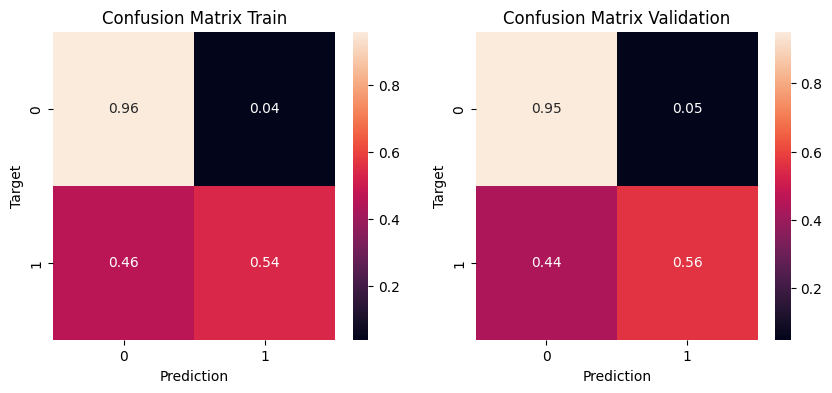

In [33]:
model_1.display_confusion_matrix()

 F1 Score

In [34]:
model_1.get_f1_score()

F1-score: Train: 0.6352, Validation: 0.6412


 ROC Curve та AUROC

AUROC for Train: 0.8824
AUROC for Train: 0.8797


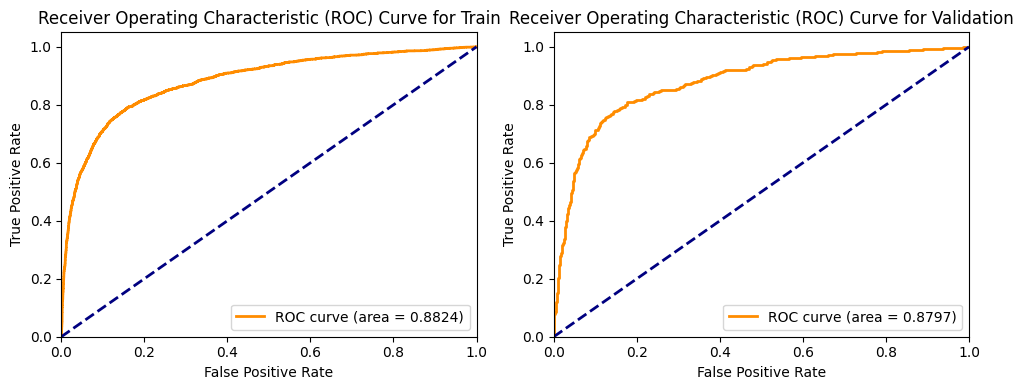

In [35]:
model_1.roc_auc()

#### Висновки

**Accuracy**:
Точність є достаньо високою для  Training = 87%  та для Validation = 87%. Це говорить про те, що модель правильно класифікує приблизно 87% випадків як на тренувальній, так і на валідаційній вибірках.

З **Confusion Matrix** можемо бачити:
- Для трейнинг: модель добре розпізнає негативні класи 96% та позитивні класи 54%; 4% негативних випадків, що були класифіковані як позитивні, та 46% позитивних відсотків, які модель не виявила, та відмітила їх як негативні.

- Для валідейшн: модель добре розпізнає негативні класи 95% та позитивні класи 56%; 5% негативних випадків, що були класифіковані як позитивні, та 44% позитивних відсотків, які модель не виявила, та відмітила їх як негативні.
Отже можемо сказати, що результати матриці плутанини схожі до тренувальної вибірки та є покращення у виявленні позитивного класу.

**ROC та AUROC**:
Маємо значення AUROC:
- Training 0.88
- Validation 0.88

Бачимо, що значення приблизно однакові для обох наборів даних. Також можемо сказати, що значення AUROC достатньо високе, що може свідчити про те, що модель досить добре справляється з класифікацією.


 **F1-score**
Маємо значення F1:
- Training 0.63
- Validation 0.64

Бачимо невелику різницю між тренувальними та валідіційними наборами.

Загалом модель показує хороші результати із загальною точністю 87% та AUROC = 0.88.

Отже модель показує гіршу точність при визначення класу 1. В той же час модель гарно працює для визначення каласу 0, який є мажоритарним.

In [36]:
y_train.value_counts(normalize=True)

,proportion
Exited,
0.0,0.7965
1.0,0.2035


Так як у нас вібірка не збалансована, можемо спробувати балансувати, та подивитись на матрицю плутанини.

Accuracy: 
Train: 0.8227, Validation: 0.8087
F1-score: Train: 0.6477, Validation: 0.6316


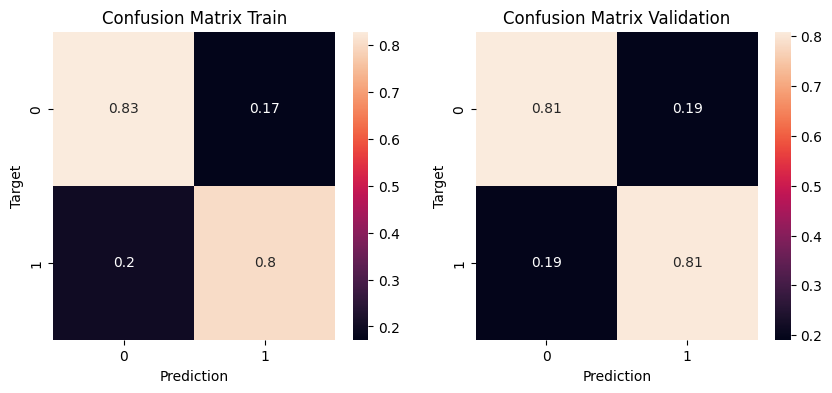

AUROC for Train: 0.8838
AUROC for Train: 0.8800


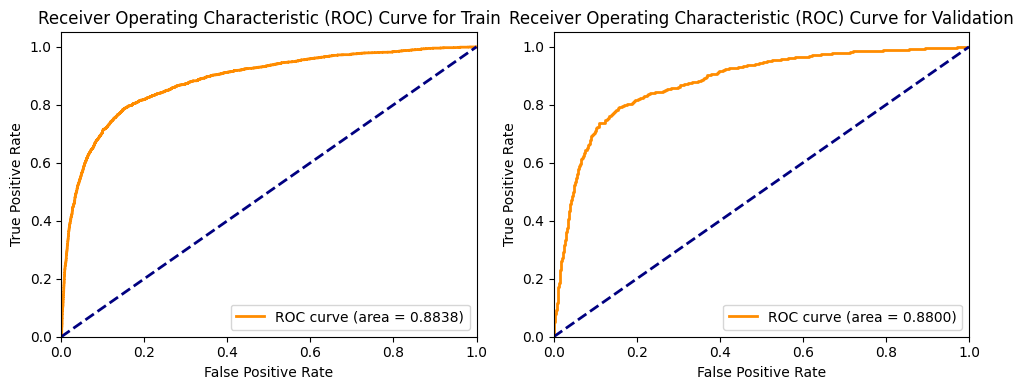

In [37]:
model_balanced = LogModel(X_train, y_train, X_val, y_val, class_weight='balanced').fit().predict()
model_balanced.accuracy()
model_balanced.get_f1_score()
model_balanced.display_confusion_matrix()
model_balanced.roc_auc()


Спостереження:

Після спроби балансування класів з матриці плутанини бачимо, що модель стала помилятися менше при визначенні позитивного класу. Метрики AUROC  дещо покращилась для тренувального набору, та погіршилась для валідаційного.

### Завдання 8

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

Бачимо, що майже 80% у тренувальних данних це класс 0.
Отже мажоритарний класс - 0.

In [38]:
model_0 = LogModel(X_train, y_train, X_val, y_val, pos_label=0).fit().predict()

In [39]:
model_1.accuracy()

Accuracy: 
Train: 0.8742, Validation: 0.8717


In [40]:
model_0.accuracy()

Accuracy: 
Train: 0.8742, Validation: 0.8717


In [41]:
model_0.get_f1_score()

F1-score: Train: 0.0677, Validation: 0.0834


AUROC for Train: 0.8824
AUROC for Train: 0.8797


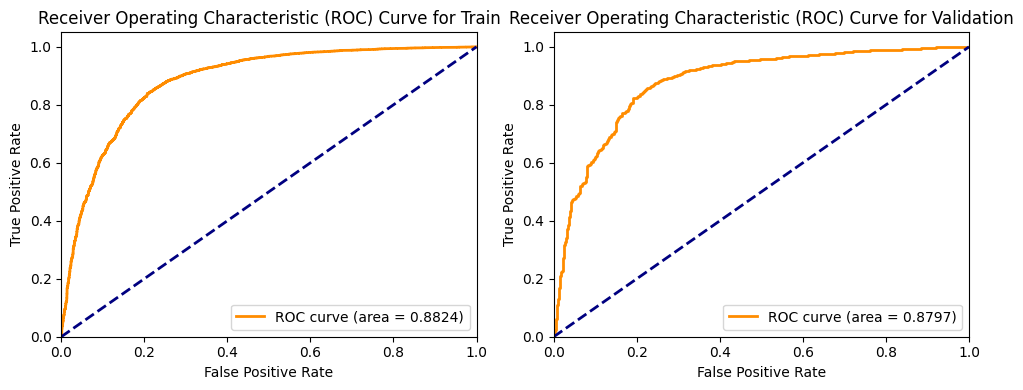

In [42]:
model_0.roc_auc()

Спостереження:

- Значення метрики Accuracy не змінилилося. Значення 0.8722 на тренувальній та 0.8733 на валідаційній вибірках виглядають досить високими.
- Значення F1-score для мінорного класу значно вищий (0.6248/0.6422), ніж для мажоритарного (0.0690/0.0656).
- Значенння AUROC досить подібні до моделі для мінорного класу.

Надзвичайно низький F1-score скоріще гвоорить про те, що модель є непридатною для використання. Можливо причина у дисбалансі класів.

### Завдання 9

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [43]:
bccp = {
    'model': model_0,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_cols,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols
}

In [44]:
joblib.dump(bccp, f'{dir_path}/bccp.joblib')

['drive/My Drive/ML/data/bccp/lab/bccp.joblib']

In [45]:
model_2 = joblib.load(f'{dir_path}/bccp.joblib')

### Завдання 10

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [46]:
model = model_1.model

In [47]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_cols, input_df: pd.DataFrame):
  input_df = input_df.copy()
  input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
  encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
  input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
  X_input = input_df[numeric_cols + encoded_cols]
  prob = model.predict_proba(X_input)[:,1]
  return prob


In [48]:
input_df = train_data[:5]
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_cols, train_data[:5])

array([0.00654092, 0.0366679 , 0.37111937, 0.37653484, 0.97577854])

### Завдання 11

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [49]:
file_name = '/content/drive/MyDrive/ML/data/bccp/test.csv'
test_df = pd.read_csv(file_name)
test_df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [50]:
test_df['Exited'] = predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_cols, test_df)
test_df.head(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.075316
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.035366
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.153210
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.194872
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.055660


### Завдання 12

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [51]:
file_name = '/content/drive/MyDrive/ML/data/bccp/sample_submission.csv'
sample = pd.read_csv(file_name)
sample.head(5)

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [52]:
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
sub_path = 'drive/My Drive/ML/data/bccp/lab/submission'

In [53]:
upd_sample = sample.copy()
upd_sample

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5
...,...,...
9995,24995,0.5
9996,24996,0.5
9997,24997,0.5
9998,24998,0.5


In [54]:
upd_sample['Exited'] = upd_sample['id'].map(test_df.set_index('id')['Exited'])

In [55]:
upd_sample

,id,Exited
0,15000,0.075316
1,15001,0.035366
2,15002,0.153210
3,15003,0.194872
4,15004,0.055660
...,...,...
9995,24995,0.022145
9996,24996,0.026017
9997,24997,0.018623
9998,24998,0.155567


In [56]:
upd_sample.to_csv(f'{sub_path}/submission_log_reg_{timestamp}.csv', index=False)